In [1]:
from Datageneration import User,CallGenerator,CallSimulator
from nonpredictor import NonPredictiveCallAdmissionController
from predictor import PredictiveCallAdmissionController, AdmissionMetrics,RAT_CAPACITIES,RATPool,RATState,RB_PER_SERVICE
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Optional, Tuple, List, Literal
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import heapq
import pandas as pd
import numpy as np
from math import exp, log, sin, cos, pi
from datetime import datetime, timedelta
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from nn import CallDurationPredictor


Duration stats (seconds):
count    89397.000000
mean       390.371804
std        295.516041
min         36.026100
25%        193.535666
50%        308.176199
75%        492.750710
max       3677.986852
Name: duration_sec, dtype: float64

Median call duration: 308 seconds
Median call duration: 5.1 minutes
Median call duration: 5 minutes 8 seconds

Weibull Distribution Parameters:
Shape parameter (k): 1.472
Scale parameter (λ): 7.252 minutes


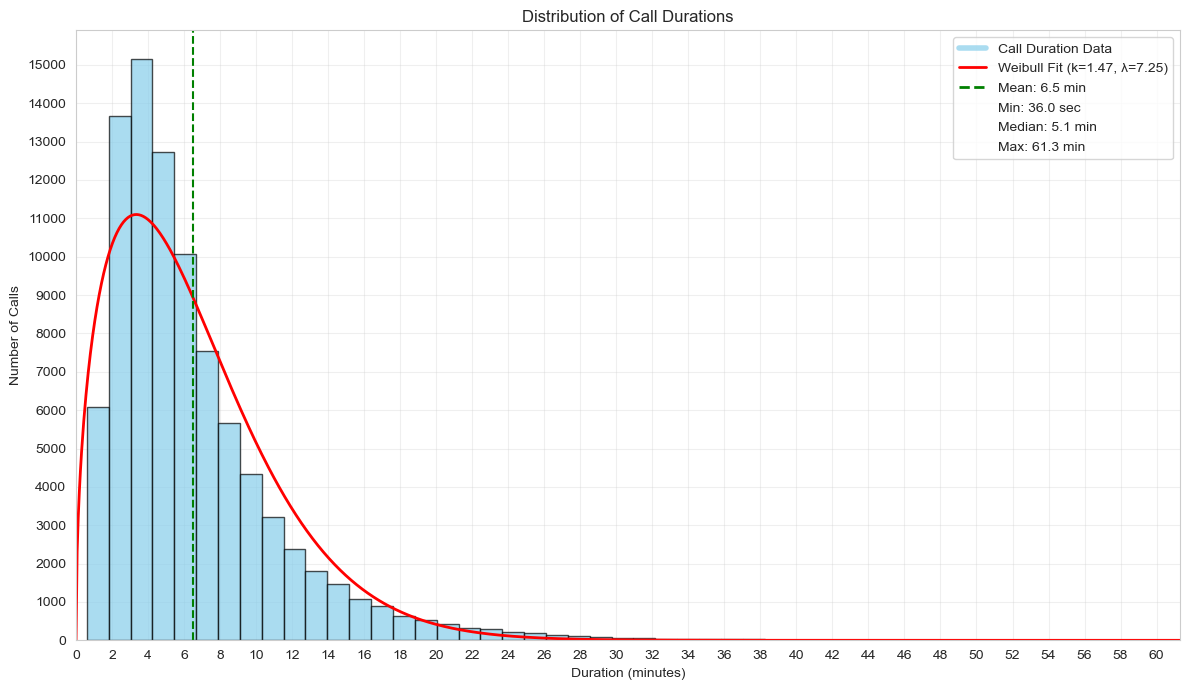


Weibull Distribution Insights:
Mean from Weibull: 6.56 minutes
Variance: 20.56


In [27]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import gamma  
df = pd.read_csv("data.csv")
# Inspect basic stats
print("Duration stats (seconds):")
print(df["duration_sec"].describe())

# Get median in seconds
median_seconds = df['duration_sec'].median()
print(f"\nMedian call duration: {median_seconds:.0f} seconds")

# Convert to minutes for easier interpretation
median_minutes = median_seconds / 60
print(f"Median call duration: {median_minutes:.1f} minutes")

# Or more precisely:
minutes = int(median_seconds // 60)
seconds = int(median_seconds % 60)
print(f"Median call duration: {minutes} minutes {seconds} seconds")

# Fit Weibull distribution to the data
data = df['duration_sec'].values / 60  # Convert to minutes
shape, loc, scale = stats.weibull_min.fit(data, floc=0)  # Fit with location=0

print(f"\nWeibull Distribution Parameters:")
print(f"Shape parameter (k): {shape:.3f}")
print(f"Scale parameter (λ): {scale:.3f} minutes")

# Calculate statistics for legend
min_duration = np.min(data)*60
max_duration = np.max(data)
median_duration = np.median(data)
mean_duration = np.mean(data)

# Create standalone figure
plt.figure(figsize=(12, 7))

n, bins, patches = plt.hist(data, bins=50, alpha=0.7, edgecolor='black', 
                           color='skyblue', density=False, label='Call Duration Data')

# Customize x-axis with 2-minute intervals
max_duration = np.max(data)
x_ticks = np.arange(0, max_duration + 2, 2)
plt.xticks(x_ticks)

# Create smooth curve for Weibull distribution (scaled to frequency)
x = np.linspace(0, max_duration, 1000)
weibull_pdf = stats.weibull_min.pdf(x, shape, loc=0, scale=scale)
# Scale the PDF to match frequency counts
bin_width = bins[1] - bins[0]
total_count = len(data)
weibull_scaled = weibull_pdf * total_count * bin_width

plt.plot(x, weibull_scaled, 'r-', linewidth=2, 
         label=f'Weibull Fit (k={shape:.2f}, λ={scale:.2f})')


plt.axvline(mean_duration, color='green', linestyle='--', 
           label=f'Mean: {mean_duration:.1f} min')

# Customize y-axis with 1000 intervals
current_y_lim = plt.gca().get_ylim()
y_ticks = np.arange(0, current_y_lim[1] + 1000, 1000)
plt.yticks(y_ticks)


plt.xlim(0, max_duration)  # X-axis from 0 to max duration
plt.ylim(0, current_y_lim[1])  # Y-axis from 0 to current max

plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Calls')
plt.title('Distribution of Call Durations')

# Create custom legend entries for min, max, median (no lines on plot)
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='skyblue', alpha=0.7, lw=4),  # For histogram
    Line2D([0], [0], color='red', lw=2),              # For Weibull curve
    Line2D([0], [0], color='green', linestyle='--', lw=2),  # For mean line
    Line2D([0], [0], color='white', lw=0),            # Empty for min
    Line2D([0], [0], color='white', lw=0),            # Empty for median  
    Line2D([0], [0], color='white', lw=0)             # Empty for max
]

labels = [
    'Call Duration Data',
    f'Weibull Fit (k={shape:.2f}, λ={scale:.2f})',
    f'Mean: {mean_duration:.1f} min',
    f'Min: {min_duration:.1f} sec',
    f'Median: {median_duration:.1f} min', 
    f'Max: {max_duration:.1f} min'
]

plt.legend(custom_lines, labels, loc='best')
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Additional Weibull insights
print(f"\nWeibull Distribution Insights:")
print(f"Mean from Weibull: {scale * gamma(1 + 1/shape):.2f} minutes")
print(f"Variance: {(scale**2) * (gamma(1 + 2/shape) - (gamma(1 + 1/shape))**2):.2f}")

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load your data
df = pd.read_csv("data.csv")

# Pick first 2, middle 2, and last 2 rows
first_rows = df.head(2)
mid = len(df) // 2
middle_rows = df.iloc[mid-4:mid]  # Get 2 middle rows
last_rows = df.tail(1)

# Combine all samples
subset = pd.concat([first_rows, middle_rows, last_rows])

# Display as a nice table
print("SAMPLE CALL RECORDS (First 2, Middle 2, Last 2)")
print("=" * 55)
display(subset)

# Count calls in different duration ranges
bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, float('inf')]
labels = ['0-1 min', '1-2 min', '2-3 min', '3-4 min', '4-5 min', '5-6 min', '6-7 min', '7-8 min', 
          '8-9 min', '9-10 min', '10-11 min', '11-12 min', '12-13 min', '13-14 min', '14-15 min', '15+ min']

# Create the binned categories
df['duration_category'] = pd.cut(df['duration_sec'], bins=bins, labels=labels, right=False)
fig, ax = plt.subplots(figsize=(min(16, 2 + 0.18*subset.shape[1]), 0.8 + 0.4*subset.shape[0]))
ax.axis('off')
tbl = ax.table(cellText=subset.values,
               colLabels=subset.columns,
               loc='center',
               cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.4)   # widen/heighten cells a bit
fig.tight_layout()
fig.savefig('sample_call_records.png', dpi=300)
plt.close(fig)
# Count calls in each category
duration_counts = df['duration_category'].value_counts().sort_index()

print("\nCall Duration Distribution:")
print("=" * 40)
for category, count in duration_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count:,} calls ({percentage:.1f}%)")

# Also show the total for verification
print(f"\nTotal calls: {len(df):,}")

SAMPLE CALL RECORDS (First 2, Middle 2, Last 2)


,caller_id,callee_id,timestamp,service_type,relationship_score,caller_location,callee_location,past_avg_duration,pair_call_count,time_since_last_call_hours,duration_sec
0,10,45,2025-01-01 00:22:32,voice,1.1,home,campus,0.000000,1,NaN,248.837576
1,24,69,2025-01-01 00:30:55,voice,1.2,home,home,0.000000,1,NaN,384.593257
44694,73,98,2025-04-16 18:02:10,video,0.4,campus,work,49.283773,6,174.280000,43.501511
44695,6,1,2025-04-16 18:08:23,voice,0.6,campus,other_outdoor,88.398029,12,489.342500,76.443275
44696,80,74,2025-04-16 18:17:10,video,0.8,work,home,140.954825,27,47.708611,149.099096
44697,38,7,2025-04-16 18:17:57,voice,0.8,inTransit,home,163.923741,18,44.697778,126.674551
89396,84,38,2025-07-30 23:46:24,voice,1.1,home,home,368.652898,55,32.148889,274.587964



Call Duration Distribution:
0-1 min: 938 calls (1.0%)
1-2 min: 6,858 calls (7.7%)
2-3 min: 11,621 calls (13.0%)
3-4 min: 12,620 calls (14.1%)
4-5 min: 11,286 calls (12.6%)
5-6 min: 9,006 calls (10.1%)
6-7 min: 7,520 calls (8.4%)
7-8 min: 6,054 calls (6.8%)
8-9 min: 4,587 calls (5.1%)
9-10 min: 3,813 calls (4.3%)
10-11 min: 2,869 calls (3.2%)
11-12 min: 2,309 calls (2.6%)
12-13 min: 1,802 calls (2.0%)
13-14 min: 1,467 calls (1.6%)
14-15 min: 1,212 calls (1.4%)
15+ min: 5,435 calls (6.1%)

Total calls: 89,397


In [29]:
def create_comprehensive_table(data):
    """Create a concise comprehensive table with key metrics"""
    
    data_minutes = data / 60
    
    comprehensive_data = {
        'Metric': [
            'Total Calls',
            'Mean Duration',
            'Median Duration',
            'Minimum Duration',
            'Maximum Duration',
            '25th Percentile (Q1)',
            '75th Percentile (Q3)',
            'Standard Deviation'
        ],
        'Value': [
            f"{len(data_minutes):,}",
            f"{np.mean(data_minutes):.2f} min",
            f"{np.percentile(data_minutes, 50):.2f} min",
            f"{np.min(data_minutes):.2f} min",
            f"{np.max(data_minutes):.2f} min",
            f"{np.percentile(data_minutes, 25):.2f} min",
            f"{np.percentile(data_minutes, 75):.2f} min",
            f"{np.std(data_minutes):.2f} min"
        ]
    }
    
    comprehensive_table = pd.DataFrame(comprehensive_data)
    
    print("KEY CALL DURATION STATISTICS")
    print("=" * 50)
    display(comprehensive_table)
    
    return comprehensive_table

# Usage for single table
comprehensive_table = create_comprehensive_table(df['duration_sec'])

KEY CALL DURATION STATISTICS


,Metric,Value
0,Total Calls,"89,397"
1,Mean Duration,6.51 min
2,Median Duration,5.14 min
3,Minimum Duration,0.60 min
4,Maximum Duration,61.30 min
5,25th Percentile (Q1),3.23 min
6,75th Percentile (Q3),8.21 min
7,Standard Deviation,4.93 min


Model and metrics loaded successfully!


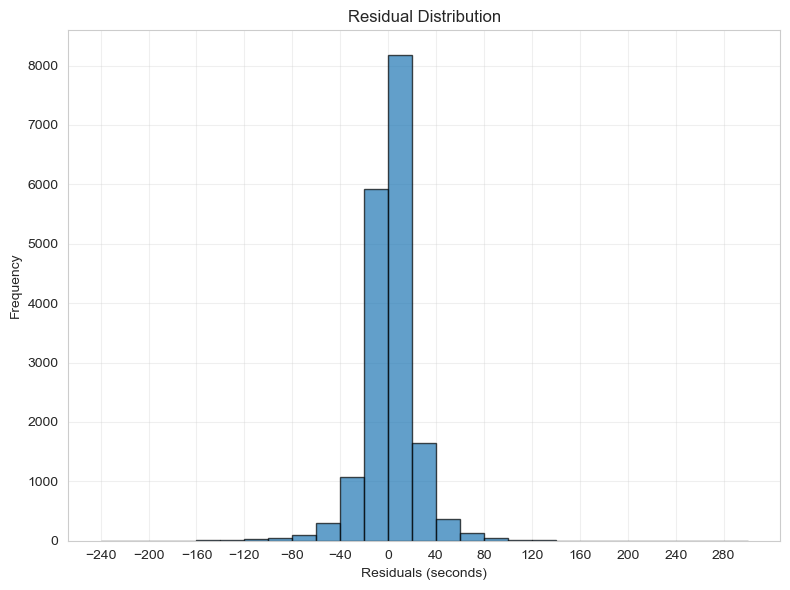

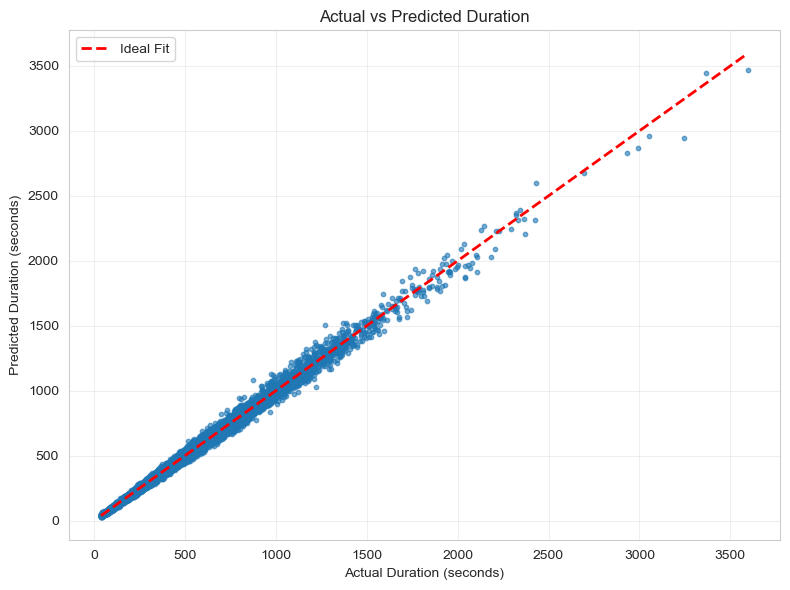

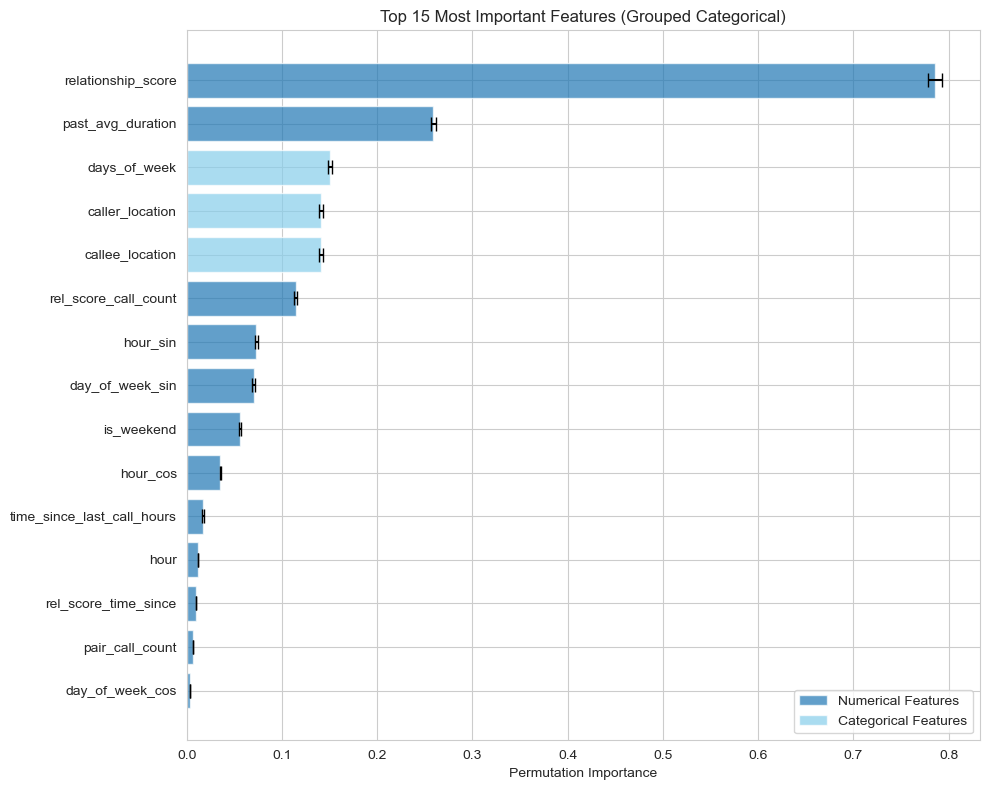


FEATURE IMPORTANCE SUMMARY:
relationship_score          0.7859 (Numerical)
past_avg_duration           0.2589 (Numerical)
days_of_week                0.1507 (Categorical)
caller_location             0.1415 (Categorical)
callee_location             0.1407 (Categorical)
rel_score_call_count        0.1143 (Numerical)
hour_sin                    0.0732 (Numerical)
day_of_week_sin             0.0703 (Numerical)
is_weekend                  0.0559 (Numerical)
hour_cos                    0.0351 (Numerical)
time_since_last_call_hours   0.0171 (Numerical)
hour                        0.0121 (Numerical)
rel_score_time_since        0.0100 (Numerical)
pair_call_count             0.0070 (Numerical)
day_of_week_cos             0.0037 (Numerical)


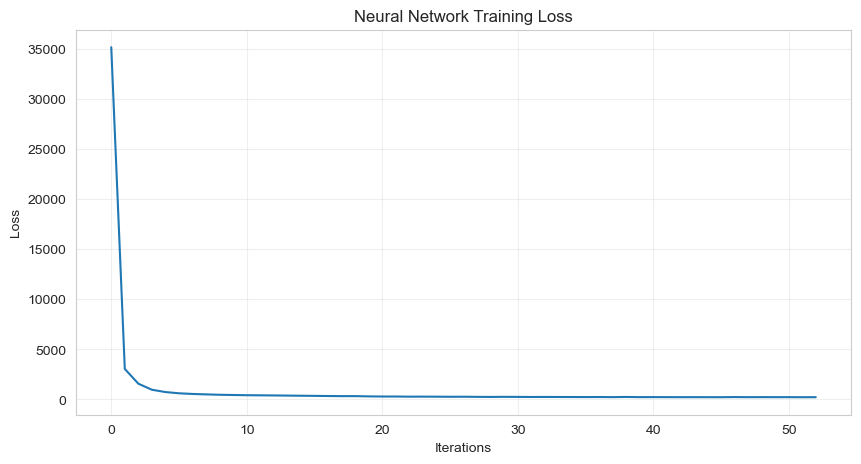

Final training loss: 224.3946
Training metrics: {'r2': 0.9951732580441874, 'rmse': 20.612624589493137, 'mae': 13.527214809806472, 'mape': 3.744725908636614}
Test metrics: {'r2': 0.9944715344267018, 'rmse': 21.616182022919066, 'mae': 14.007429614565106, 'mape': 3.9056267719800988}


In [30]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
with open('trained_predictor.pkl', 'rb') as f:
    predictor = pickle.load(f)

# Load the metrics
with open('training_metrics.json', 'r') as f:
    metrics = json.load(f)

print("Model and metrics loaded successfully!")

# Now you can create plots without retraining
predictor.plot_residuals()
plt.show()

predictor.plot_feature_importance() 
plt.show()

predictor.plot_training_history()
plt.show()

# You can also access the metrics
print("Training metrics:", metrics['train_metrics'])
print("Test metrics:", metrics['test_metrics'])

#main experiment results

Parallel Simulation Results:
   arrival_rate_per_second  predictive_blocking_prob  \
0                      0.1                  0.000000   
1                      1.0                  0.359035   
2                      2.0                  0.573071   
3                      3.0                  0.712950   
4                      4.0                  0.783801   
5                      5.0                  0.826735   

   nonpredictive_blocking_prob  
0                     0.000000  
1                     0.350793  
2                     0.571226  
3                     0.712970  
4                     0.784201  
5                     0.826526  
   arrival_rate_per_second  predictive_handoffs  nonpredictive_handoffs
0                      0.1                   66                    7053
1                      1.0                17659                   33670
2                      2.0                39020                   40685
3                      3.0                40935            

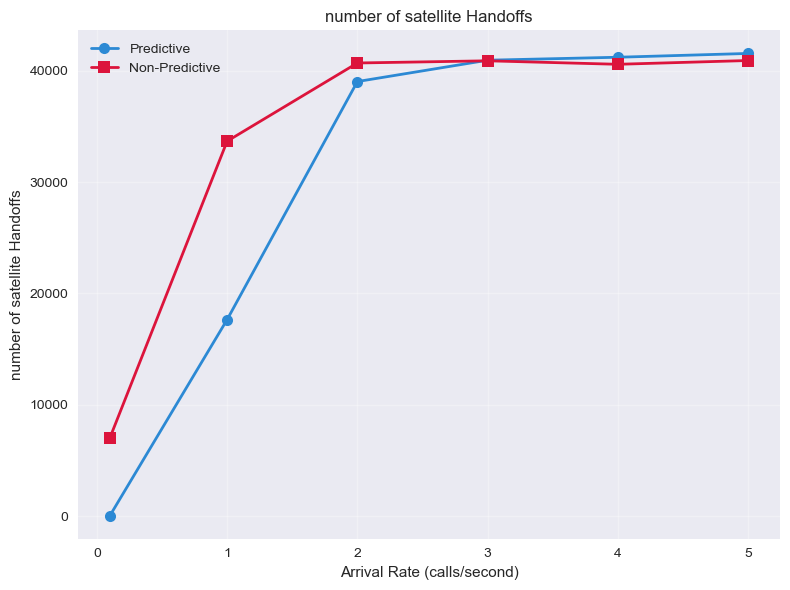

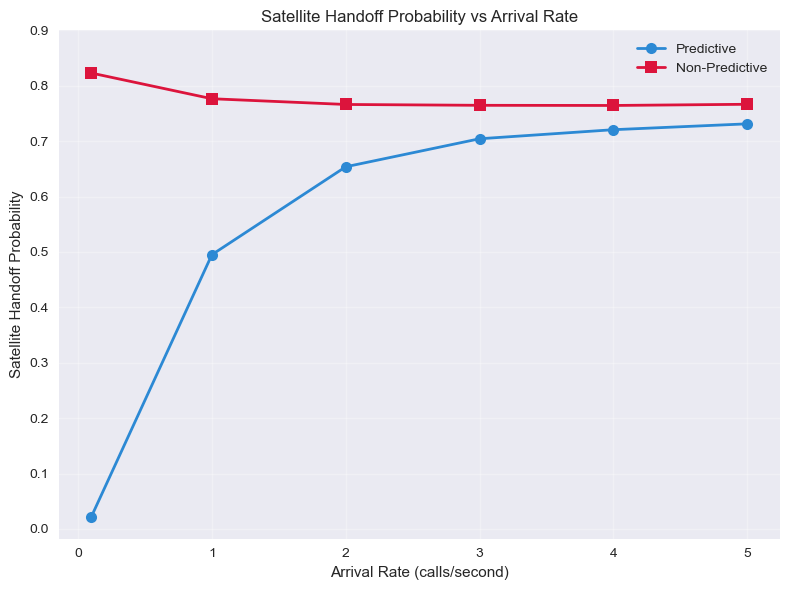

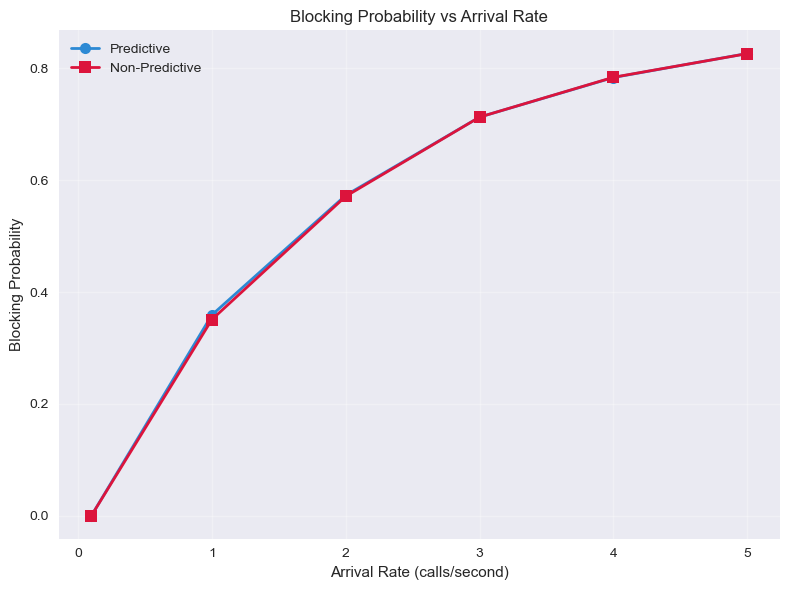

In [48]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the parallel results
with open('arrival_rate_resultsmainupdated.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results:")
print(df_results[['arrival_rate_per_second', 'predictive_blocking_prob', 'nonpredictive_blocking_prob']])
print(df_results[['arrival_rate_per_second', 'predictive_handoffs', 'nonpredictive_handoffs']])
print(df_results[['arrival_rate_per_second', 'predictive_handoff_prob', 'nonpredictive_handoff_prob_']])

# Set custom colors
PREDICTIVE_COLOR = '#2C89D4'      # or '#1f77b4' for specific #2C89D4
NON_PREDICTIVE_COLOR = '#DC143C'   # or '#d62728' for specific red

# Plot 1: Handoffs
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('number of satellite Handoffs')
plt.title('number of satellite Handoffs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Satellite Handoff Probability
# Plot 2: Satellite Handoff Probability
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_prob'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Satellite Handoff Probability')
plt.title('Satellite Handoff Probability vs Arrival Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis ticks with 0.1 increments
plt.yticks(np.arange(0, 1, 0.1))  # From 0 to 1.0 in 0.1 steps
plt.tight_layout()
plt.show()

# Plot 3: Blocking Probability
plt.figure(figsize=(8, 6))
plt.plot(df_results['arrival_rate_per_second'], df_results['predictive_blocking_prob'], 
         'o-', color=PREDICTIVE_COLOR, label='Predictive', linewidth=2, markersize=8)
plt.plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_blocking_prob'], 
         's-', color=NON_PREDICTIVE_COLOR, label='Non-Predictive', linewidth=2, markersize=8)
plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Blocking Probability')
plt.title('Blocking Probability vs Arrival Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Different groups configuration results

Parallel Simulation Results (Predictive Only):
     config_name  arrival_rate_per_second  predictive_blocking_prob
0   Group_A_100%                      0.3                  0.003563
1   Group_A_100%                      1.0                  0.216031
2   Group_A_100%                      2.0                  0.372514
3   Group_A_100%                      3.0                  0.481372
4   Group_A_100%                      4.0                  0.574791
5   Group_A_100%                      5.0                  0.651900
6   Group_B_100%                      0.3                  0.003888
7   Group_B_100%                      1.0                  0.219499
8   Group_B_100%                      2.0                  0.378709
9   Group_B_100%                      3.0                  0.481002
10  Group_B_100%                      4.0                  0.576980
11  Group_B_100%                      5.0                  0.653692
12  Group_C_100%                      0.3                  0.016053
1

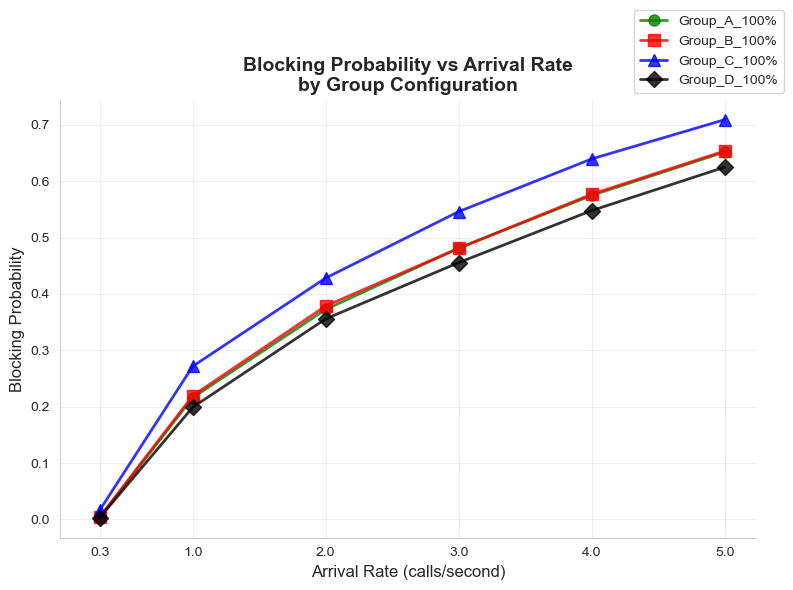

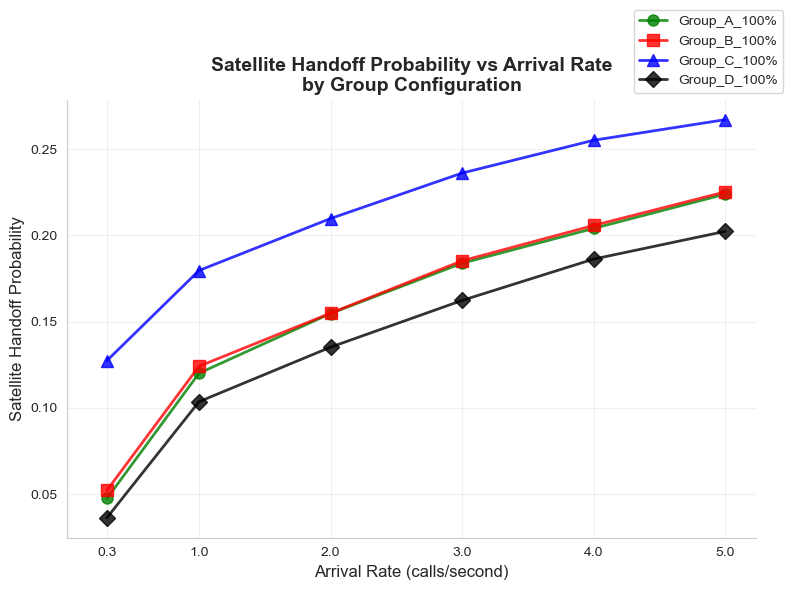

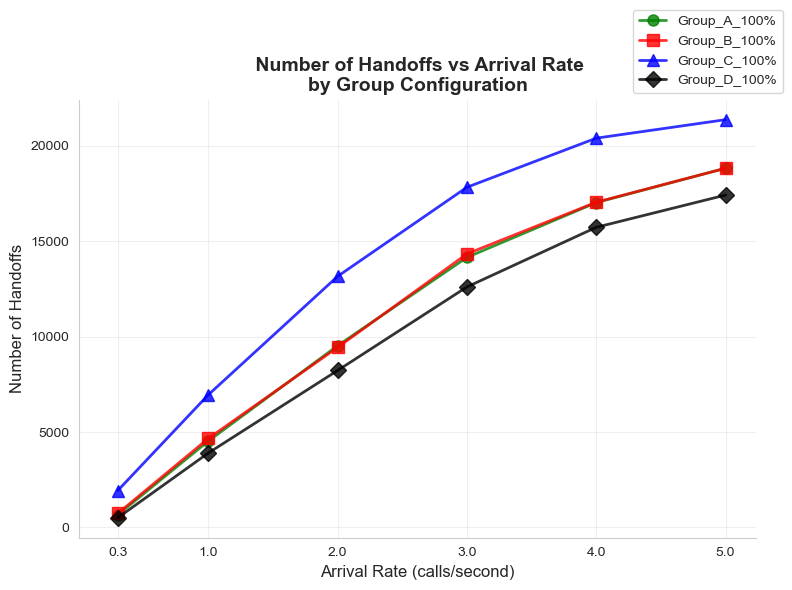


COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)
Configuration  Arrival Rate (calls/sec) Predictive Blocking Prob Predictive Handoff Prob  Predictive Handoffs  Total Calls
 Group_A_100%                       0.3                   0.0036                  0.0474                  662        24700
 Group_A_100%                       1.0                   0.2160                  0.1200                 4529        82937
 Group_A_100%                       2.0                   0.3725                  0.1547                 9528       166053
 Group_A_100%                       3.0                   0.4814                  0.1838                14158       248718
 Group_A_100%                       4.0                   0.5748                  0.2040                17031       331823
 Group_A_100%                       5.0                   0.6519                  0.2239                18833       414453
 Group_B_100%                       0.3                   0.0039                  0.0521    

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Load the results
with open('arrival_rate_results_multiple_groupsvary1.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results (Predictive Only):")
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_blocking_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoff_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoffs']])

# Define color palette with green, red, blue, black
COLORS = ['green', 'red', 'blue', 'black']

# Get unique configurations and markers
configs = df_results['config_name'].unique()
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

# PLOT 1: BLOCKING PROBABILITY (Predictive Only)
plt.figure(figsize=(8, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_blocking_prob'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Blocking Probability', fontsize=12)
plt.title('Blocking Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 2: HANDOFF PROBABILITY (Predictive Only)
plt.figure(figsize=(8, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoff_prob'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Satellite Handoff Probability', fontsize=12)
plt.title('Satellite Handoff Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 3: NUMBER OF HANDOFFS (Predictive Only)
plt.figure(figsize=(8, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoffs'], 
             marker=markers[idx], linestyle='-', 
             color=COLORS[idx % len(COLORS)], alpha=0.8,
             label=f'{config}', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Number of Handoffs', fontsize=12)
plt.title(' Number of Handoffs vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
plt.xlim(left=0)  # Remove space between y-axis and x=0
sns.despine()
plt.tight_layout()
plt.show()

# Print comprehensive summary table (Predictive Only)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)")
print("="*80)

summary_data = []
for config in configs:
    config_data = df_results[df_results['config_name'] == config]
    for _, row in config_data.iterrows():
        summary_data.append({
            'Configuration': config,
            'Arrival Rate (calls/sec)': row['arrival_rate_per_second'],
            'Predictive Blocking Prob': f"{row['predictive_blocking_prob']:.4f}",
            'Predictive Handoff Prob': f"{row['predictive_handoff_prob']:.4f}",
            'Predictive Handoffs': row['predictive_handoffs'],
            'Total Calls': row['total_calls']
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

same group differet configurations

Parallel Simulation Results (Predictive Only):
     config_name  arrival_rate_per_second  predictive_blocking_prob
0   Group_A_100%                      0.3                  0.064441
1   Group_A_100%                      1.0                  0.367354
2   Group_A_100%                      2.0                  0.567159
3   Group_A_100%                      3.0                  0.700408
4   Group_A_100%                      4.0                  0.773182
5   Group_A_100%                      5.0                  0.817176
6    Group_A_50%                      0.3                  0.007987
7    Group_A_50%                      1.0                  0.272632
8    Group_A_50%                      2.0                  0.446784
9    Group_A_50%                      3.0                  0.576529
10   Group_A_50%                      4.0                  0.676498
11   Group_A_50%                      5.0                  0.742483
     config_name  arrival_rate_per_second  predictive_handoff_prob
0 

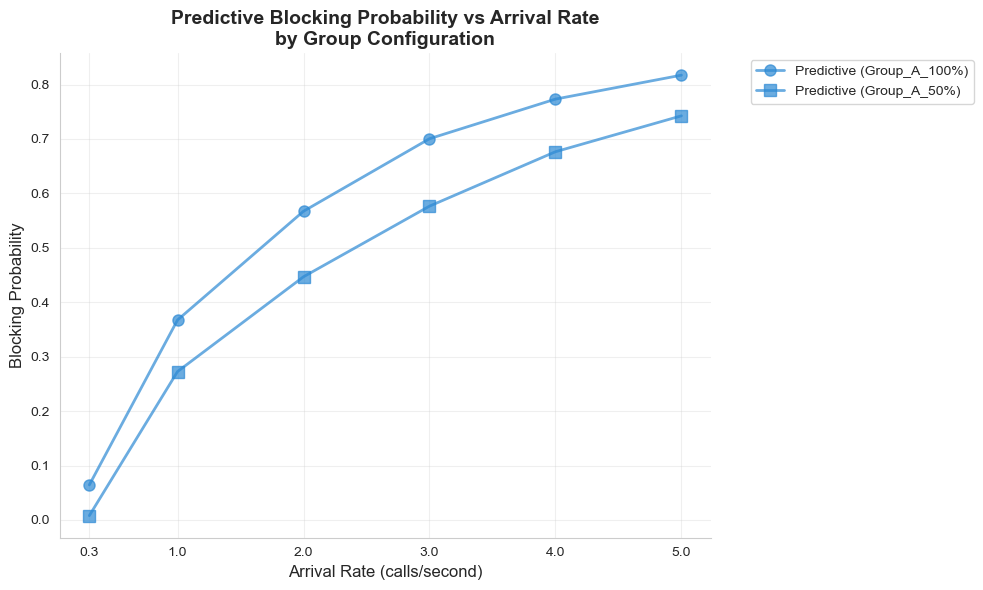

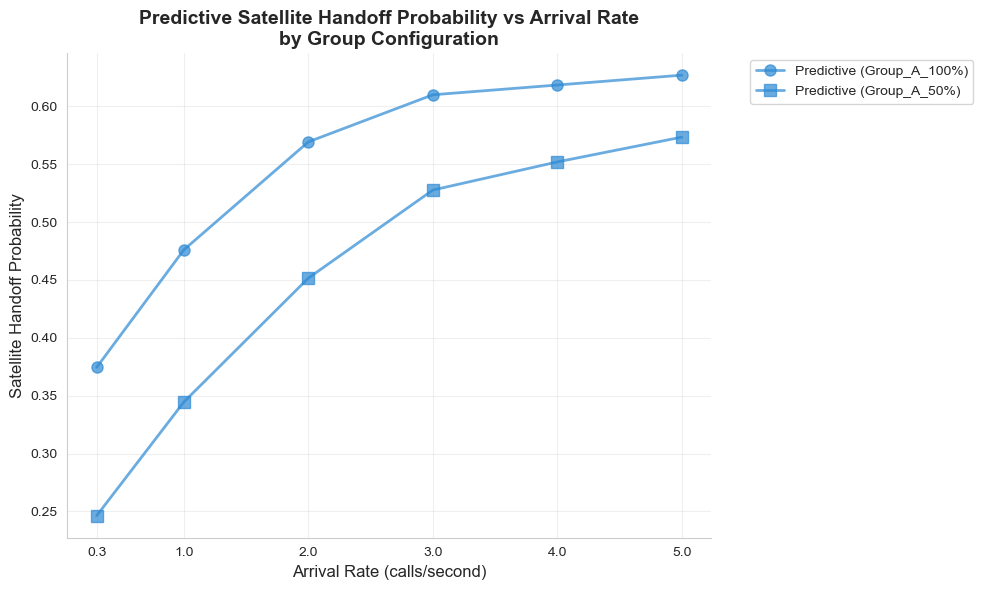

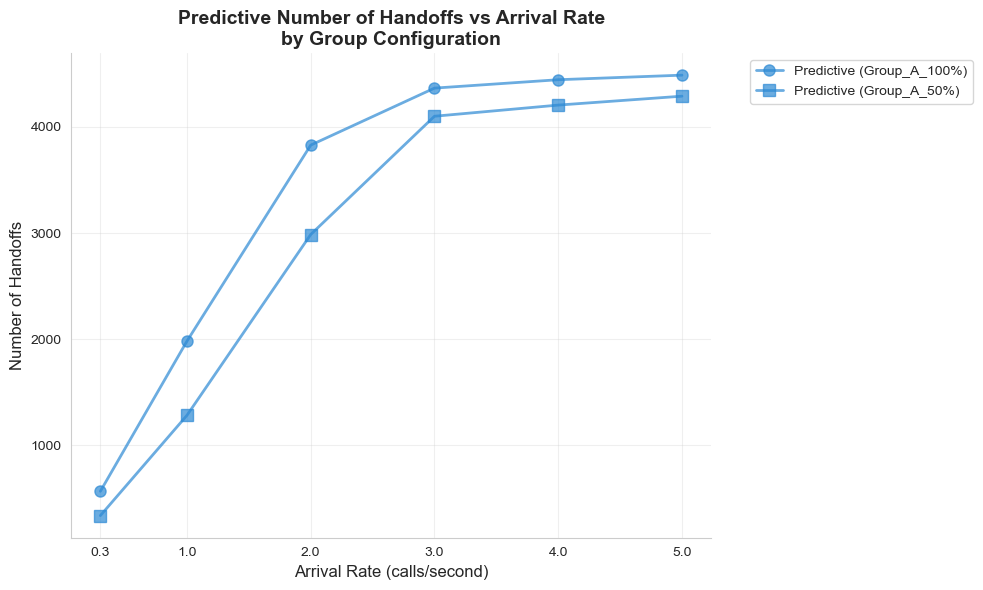


COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)
Configuration  Arrival Rate (calls/sec) Predictive Blocking Prob Predictive Handoff Prob  Predictive Handoffs  Total Calls
 Group_A_100%                       0.3                   0.0644                  0.3745                  567         4283
 Group_A_100%                       1.0                   0.3674                  0.4760                 1982        14354
 Group_A_100%                       2.0                   0.5672                  0.5692                 3828        28611
 Group_A_100%                       3.0                   0.7004                  0.6099                 4365        43142
 Group_A_100%                       4.0                   0.7732                  0.6183                 4444        57522
 Group_A_100%                       5.0                   0.8172                  0.6269                 4487        72064
  Group_A_50%                       0.3                   0.0080                  0.2464    

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Load the results
with open('arrival_rate_results_multiple_groupsupdated.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("Parallel Simulation Results (Predictive Only):")
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_blocking_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoff_prob']])
print(df_results[['config_name', 'arrival_rate_per_second', 'predictive_handoffs']])

# Set custom color for predictive only
PREDICTIVE_COLOR = '#2C89D4'

# Get unique configurations and markers
configs = df_results['config_name'].unique()
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

# PLOT 1: BLOCKING PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_blocking_prob'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Blocking Probability', fontsize=12)
plt.title('Predictive Blocking Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 2: HANDOFF PROBABILITY (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoff_prob'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Satellite Handoff Probability', fontsize=12)
plt.title('Predictive Satellite Handoff Probability vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# PLOT 3: NUMBER OF HANDOFFS (Predictive Only)
plt.figure(figsize=(10, 6))
for idx, config in enumerate(configs):
    config_data = df_results[df_results['config_name'] == config]
    
    plt.plot(config_data['arrival_rate_per_second'], 
             config_data['predictive_handoffs'], 
             marker=markers[idx], linestyle='-', 
             color=PREDICTIVE_COLOR, alpha=0.7,
             label=f'Predictive ({config})', linewidth=2, markersize=8)

plt.xlabel('Arrival Rate (calls/second)', fontsize=12)
plt.ylabel('Number of Handoffs', fontsize=12)
plt.title('Predictive Number of Handoffs vs Arrival Rate\nby Group Configuration', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(df_results['arrival_rate_per_second'].unique())
sns.despine()
plt.tight_layout()
plt.show()

# Print comprehensive summary table (Predictive Only)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE (PREDICTIVE ONLY)")
print("="*80)

summary_data = []
for config in configs:
    config_data = df_results[df_results['config_name'] == config]
    for _, row in config_data.iterrows():
        summary_data.append({
            'Configuration': config,
            'Arrival Rate (calls/sec)': row['arrival_rate_per_second'],
            'Predictive Blocking Prob': f"{row['predictive_blocking_prob']:.4f}",
            'Predictive Handoff Prob': f"{row['predictive_handoff_prob']:.4f}",
            'Predictive Handoffs': row['predictive_handoffs'],
            'Total Calls': row['total_calls']
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Service type results

Loading simulation results...
Results loaded:
Voice calls: 6 simulations
Video calls: 7 simulations

Generating predictive metrics only...


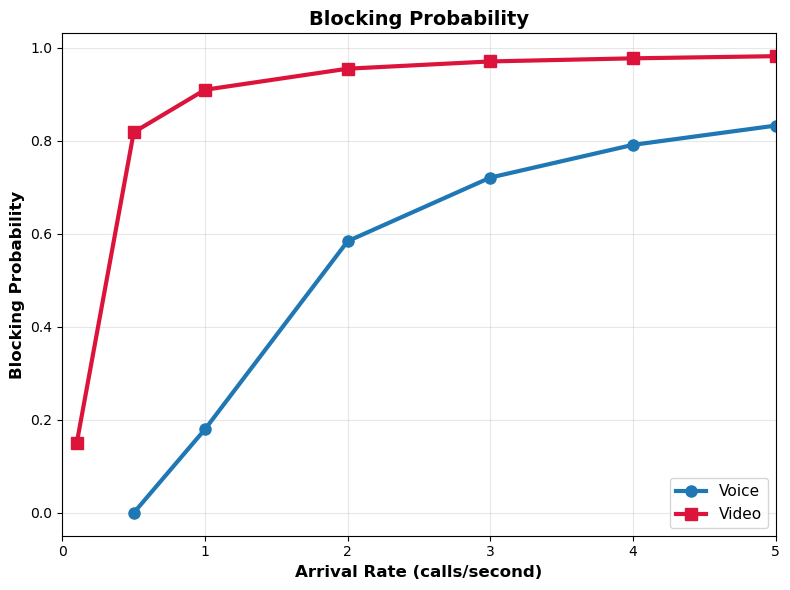

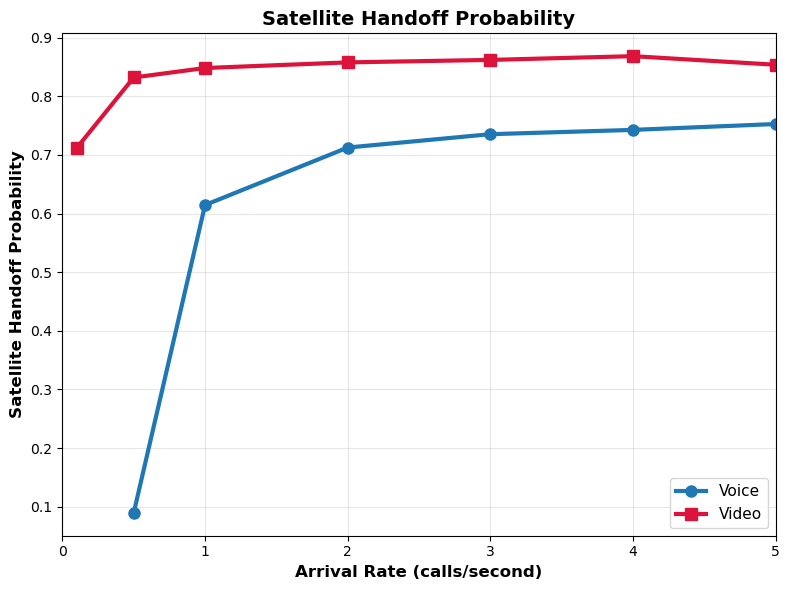

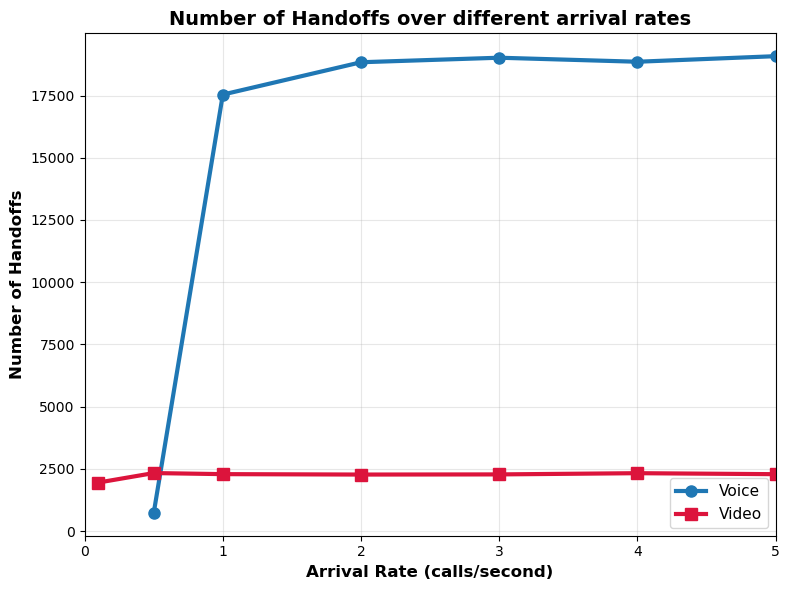


PREDICTIVE METRICS PLOTS GENERATED!


In [5]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_results(filename='service_type_different_rates_results1.pkl'):
    """Load and separate the simulation results by service type"""
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame and filter errors
    df = pd.DataFrame(results)
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Separate by service type
    voice_df = df[df['service_type'] == 'voice'].sort_values('arrival_rate_per_second')
    video_df = df[df['service_type'] == 'video'].sort_values('arrival_rate_per_second')
    
    print("Results loaded:")
    print(f"Voice calls: {len(voice_df)} simulations")
    print(f"Video calls: {len(video_df)} simulations")
    
    return voice_df, video_df

def plot_predictive_metrics_only(voice_df, video_df):
    """Plot only predictive metrics for both voice and video in separate graphs"""
    
    # Plot 1: Predictive Blocking Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_blocking_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_blocking_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Blocking Probability', fontsize=12, fontweight='bold')
    plt.title('Blocking Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Predictive Handoff Probability
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoff_prob'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoff_prob'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Satellite Handoff Probability', fontsize=12, fontweight='bold')
    plt.title('Satellite Handoff Probability', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Predictive Absolute Handoffs
    plt.figure(figsize=(8, 6))
    
    if len(voice_df) > 0:
        plt.plot(voice_df['arrival_rate_per_second'], 
                voice_df['predictive_handoffs'], 
                marker='o', linewidth=3, markersize=8,
                color='#1f77b4', linestyle='-',
                label='Voice')
    
    if len(video_df) > 0:
        plt.plot(video_df['arrival_rate_per_second'], 
                video_df['predictive_handoffs'], 
                marker='s', linewidth=3, markersize=8,
                color='#DC143C', linestyle='-',
                label='Video')
    
    plt.xlabel('Arrival Rate (calls/second)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Handoffs', fontsize=12, fontweight='bold')
    plt.title('Number of Handoffs over different arrival rates', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)  # Changed to lower right
    plt.grid(True, alpha=0.3)
    
    # Remove gap between y-axis and x-axis
    plt.margins(x=0)
    plt.xlim(left=0)
    
    plt.tight_layout()
    plt.show()

def generate_predictive_only_plots():
    """Generate only predictive metrics plots"""
    
    print("Loading simulation results...")
    voice_df, video_df = load_results()
    
    print("\nGenerating predictive metrics only...")
    plot_predictive_metrics_only(voice_df, video_df)
    
    print("\n" + "=" * 50)
    print("PREDICTIVE METRICS PLOTS GENERATED!")
    print("=" * 50)

# Run the predictive-only analysis
if __name__ == "__main__":
    generate_predictive_only_plots()

different accuracy results

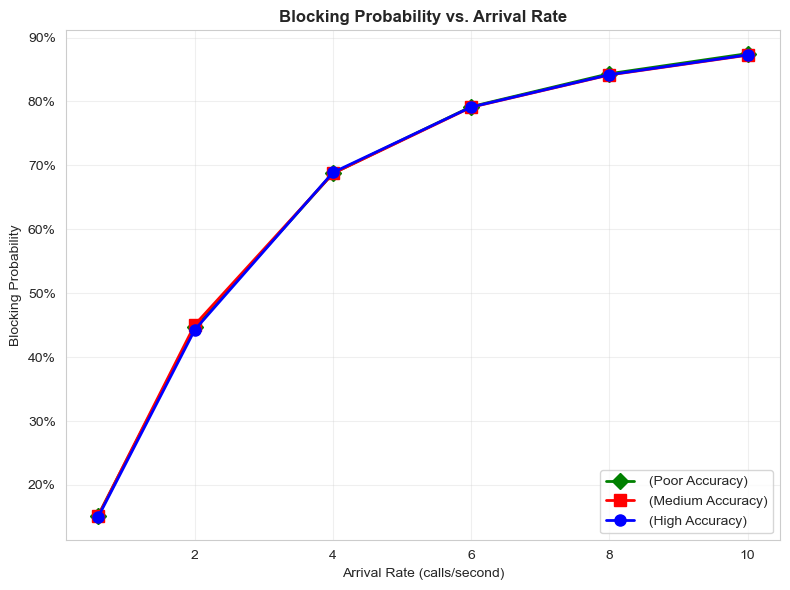

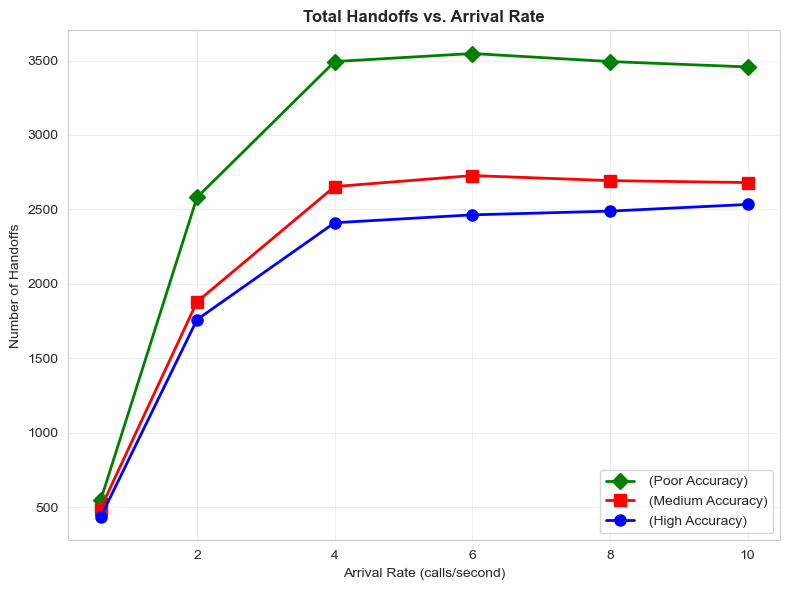

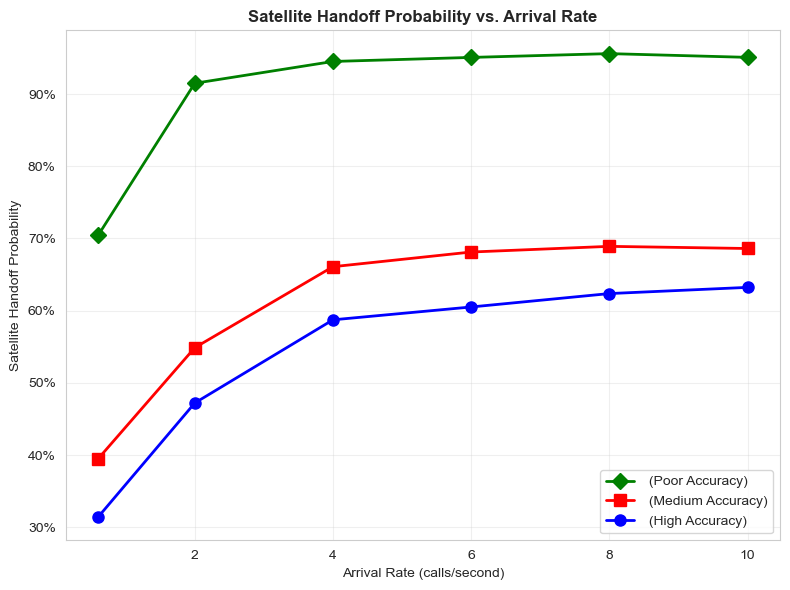


SUMMARY TABLE
 Accuracy Level  R² Score  Arrival Rate (calls/sec) Predictive Blocking Prob Non-Predictive Blocking Prob Blocking Improvement  Predictive Handoffs  Non-Predictive Handoffs Predictive Handoff Prob Non-Predictive Handoff Prob
  High Accuracy  0.998350                       0.6                    0.150                        0.152                 1.5%                  432                     1189                   0.314                       0.697
  High Accuracy  0.998350                       2.0                    0.443                        0.445                 0.4%                 1759                     2246                   0.472                       0.671
  High Accuracy  0.998350                       4.0                    0.689                        0.691                 0.3%                 2410                     2526                   0.587                       0.674
  High Accuracy  0.998350                       6.0                    0.791         

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_multi_accuracy_results(results_file):
    """
    Plot blocking probability, number of handoffs, and handoff probability
    across different accuracy levels, each in a separate figure.
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Remove any results with errors
    df = df[~df.apply(lambda x: 'error' in x and x['error'] is not None, axis=1)]
    
    # Set white background style
    plt.style.use('default')  # Use default style instead of seaborn
    sns.set_style("whitegrid")  # White background with grid
    
    # Get unique accuracy levels and sort by R² score
    accuracy_levels = sorted(df['accuracy_label'].unique(), 
                           key=lambda x: df[df['accuracy_label'] == x]['r2_score'].iloc[0])
    
    # Define colors and markers for different accuracy levels
    colors = {'High Accuracy': "blue",    # Blue
              'Medium Accuracy': 'red',   # Red
              'Low Accuracy': "orange",    # Green
              'Poor Accuracy': 'green'}  # Orange 
    
    markers = {'High Accuracy': 'o', 
               'Medium Accuracy': 's', 
               'Low Accuracy': '^', 
               'Poor Accuracy': 'D'}
    
    # Use solid lines for all (no dashed lines)
    line_styles = {'High Accuracy': '-', 
                   'Medium Accuracy': '-', 
                   'Low Accuracy': '-', 
                   'Poor Accuracy': '-'}
    
    # Plot 1: Blocking Probability Comparison
    plt.figure(figsize=(8, 6), facecolor='white')
    ax1 = plt.gca()
    ax1.set_facecolor('white')
    
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        # Plot predictive controller
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_blocking_prob'],
                 label=f' ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)

    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Blocking Probability')
    plt.title('Blocking Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')  # Changed to lower right inside graph
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Number of Handoffs
    plt.figure(figsize=(8, 6), facecolor='white')
    ax2 = plt.gca()
    ax2.set_facecolor('white')
    
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoffs'],
                 label=f' ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
    
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Number of Handoffs')
    plt.title('Total Handoffs vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')  # Changed to lower right inside graph
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Handoff Probability
    plt.figure(figsize=(8, 6), facecolor='white')
    ax3 = plt.gca()
    ax3.set_facecolor('white')
    
    for accuracy in accuracy_levels:
        accuracy_data = df[df['accuracy_label'] == accuracy].sort_values('arrival_rate_per_second')
        
        plt.plot(accuracy_data['arrival_rate_per_second'], 
                 accuracy_data['predictive_handoff_prob'],
                 label=f' ({accuracy})',
                 color=colors.get(accuracy, '#000000'),
                 marker=markers.get(accuracy, 'o'),
                 linestyle=line_styles.get(accuracy, '-'),
                 linewidth=2,
                 markersize=8)
        
      
    plt.xlabel('Arrival Rate (calls/second)')
    plt.ylabel('Satellite Handoff Probability')
    plt.title('Satellite Handoff Probability vs. Arrival Rate', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')  # Changed to lower right inside graph
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()
    
    return df


def create_summary_table(results_file):
    """
    Create a summary table of the results
    """
    
    # Load results
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Create summary table
    summary_data = []
    
    for accuracy in df['accuracy_label'].unique():
        accuracy_data = df[df['accuracy_label'] == accuracy]
        r2_score = accuracy_data['r2_score'].iloc[0]
        
        for rate in sorted(accuracy_data['arrival_rate_per_second'].unique()):
            rate_data = accuracy_data[accuracy_data['arrival_rate_per_second'] == rate].iloc[0]
            
            summary_data.append({
                'Accuracy Level': accuracy,
                'R² Score': r2_score,
                'Arrival Rate (calls/sec)': rate,
                'Predictive Blocking Prob': f"{rate_data['predictive_blocking_prob']:.3f}",
                'Non-Predictive Blocking Prob': f"{rate_data['nonpredictive_blocking_prob']:.3f}",
                'Blocking Improvement': f"{(rate_data['nonpredictive_blocking_prob'] - rate_data['predictive_blocking_prob']) / rate_data['nonpredictive_blocking_prob']:.1%}",
                'Predictive Handoffs': int(rate_data['predictive_handoffs']),
                'Non-Predictive Handoffs': int(rate_data['nonpredictive_handoffs']),
                'Predictive Handoff Prob': f"{rate_data['predictive_handoff_prob']:.3f}",
                'Non-Predictive Handoff Prob': f"{rate_data['nonpredictive_handoff_prob_']:.3f}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Usage example:
if __name__ == "__main__":
    # Replace with your actual results file name
    results_file = 'arrival_rate_results_multiaccuracy_20251021_234346.pkl'
    
    try:
        # Plot all results
        df = plot_multi_accuracy_results(results_file)
        
        # Create and display summary table
        summary_table = create_summary_table(results_file)
        print("\n" + "="*100)
        print("SUMMARY TABLE")
        print("="*100)
        print(summary_table.to_string(index=False))
        
        # Save summary table to CSV
        summary_table.to_csv('simulation_results_summary.csv', index=False)
        print(f"\nSummary table saved to 'simulation_results_summary.csv'")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        print("Available files:")
        import glob
        result_files = glob.glob('arrival_rate_results_multiaccuracy_20251021_234346.pkl')
        for file in result_files:
            print(f"  - {file}")

different duration results

CALL DURATION STATISTICS ANALYSIS WITH QUARTILES

DETAILED CALL DURATION STATISTICS BY SCENARIO
--------------------------------------------------------------------------------


Scenario,Mean (s),Q25 (s),Median (s),Q75 (s),Q90 (s),Min (s),Max (s)
Weekday Working Hours,195.7 ± 5.4,107.9,170.4,256.9,350.7,33.8,1135.7
Weekend,533.2 ± 32.6,255.9,432.1,690.8,1022.0,34.2,5679.2



CALL DURATION COMPARISON: WEEKDAY vs WEEKEND
--------------------------------------------------------------------------------


Metric,Weekday Working Hours,Weekend,Difference
Mean Duration (s),195.7 ± 5.4,533.2 ± 32.6,+337.5
Q25 (25th Percentile),107.9,255.9,+148.0
Median (50th Percentile),170.4,432.1,+261.7
Q75 (75th Percentile),256.9,690.8,+433.9
Q90 (90th Percentile),350.7,1022.0,+671.3
Minimum Duration (s),33.8,34.2,+0.4
Maximum Duration (s),1135.7,5679.2,+4543.5


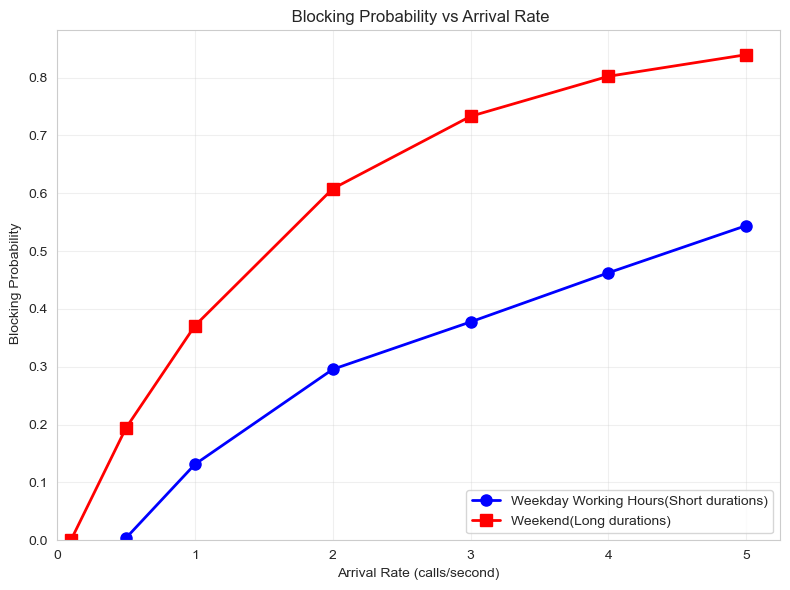

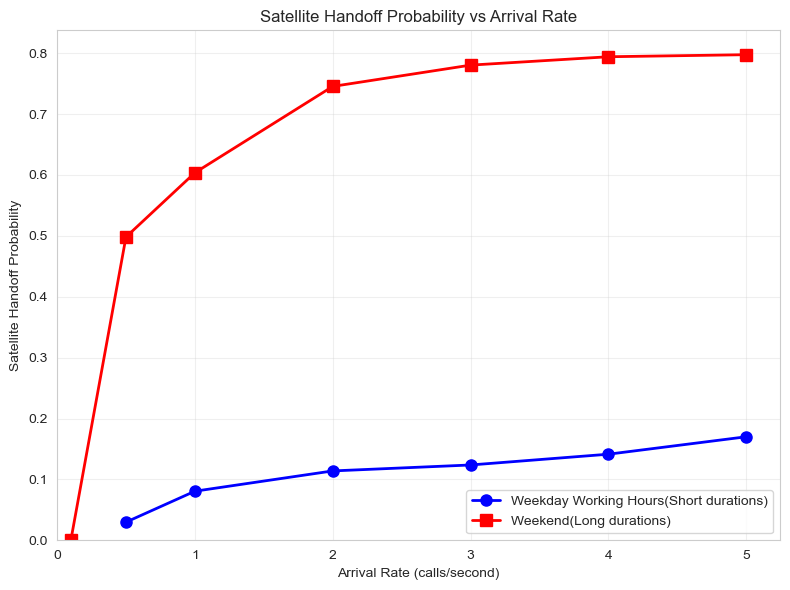

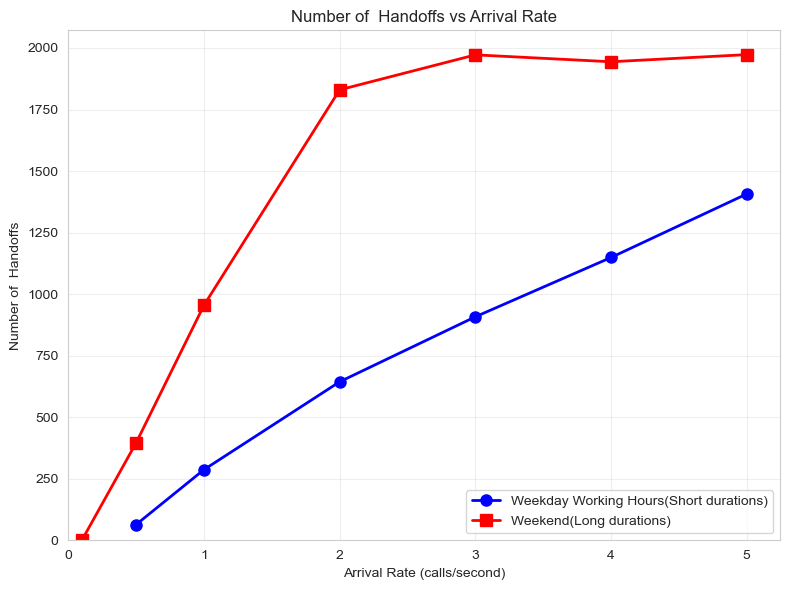


KEY INSIGHTS
• Mean call duration: 2.7x longer on weekends
• Median call duration: 2.5x longer on weekends
• 75th percentile: 2.7x longer on weekends
• Weekday: Median=170.4s, Q75=256.9s
• Weekend: Median=432.1s, Q75=690.8s
• 90% of weekday calls are under 350.7s
• 90% of weekend calls are under 1022.0s


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from IPython.display import display, HTML

# Load the results
with open('varyingduration2.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Calculate overall statistics for each scenario
scenario_stats = {}

for scenario_name, results in all_results.items():
    df = pd.DataFrame(results)
    
    # Filter out any results with errors and ensure duration_stats exists
    valid_results = [r for r in results if 'error' not in r and 'duration_stats' in r]
    if not valid_results:
        print(f"Warning: No valid results with duration_stats for {scenario_name}")
        continue
        
    # Calculate overall statistics across all arrival rates
    scenario_stats[scenario_name] = {
        'scenario_type': 'Weekday Working Hours' if 'weekday' in scenario_name else 'Weekend',
        
        # Call durations with quartiles
        'mean_duration': np.mean([r['duration_stats']['mean_duration_seconds'] for r in valid_results]),
        'std_duration': np.std([r['duration_stats']['mean_duration_seconds'] for r in valid_results]),
        'min_duration': np.min([r['duration_stats']['min_duration_seconds'] for r in valid_results]),
        'max_duration': np.max([r['duration_stats']['max_duration_seconds'] for r in valid_results]),
        'q25_duration': np.mean([r['duration_stats']['q25_duration_seconds'] for r in valid_results]),
        'median_duration': np.mean([r['duration_stats']['median_duration_seconds'] for r in valid_results]),
        'q75_duration': np.mean([r['duration_stats']['q75_duration_seconds'] for r in valid_results]),
        'q90_duration': np.mean([r['duration_stats']['q90_duration_seconds'] for r in valid_results]),
        
        # For plotting
        'arrival_rates': df['arrival_rate_per_second'].tolist(),
        'blocking_probs': df['predictive_blocking_prob'].tolist(),
        'handoff_probs': df['predictive_handoff_prob'].tolist(),
        'num_handoffs': df['predictive_handoffs'].tolist()
    }

# Create call duration statistics table with quartiles
def create_duration_table():
    """Create a call duration statistics table with quartiles"""
    data = []
    for scenario_name, stats in scenario_stats.items():
        data.append({
            'Scenario': stats['scenario_type'],
            'Mean (s)': f"{stats['mean_duration']:.1f} ± {stats['std_duration']:.1f}",
            'Q25 (s)': f"{stats['q25_duration']:.1f}",
            'Median (s)': f"{stats['median_duration']:.1f}",
            'Q75 (s)': f"{stats['q75_duration']:.1f}",
            'Q90 (s)': f"{stats['q90_duration']:.1f}",
            'Min (s)': f"{stats['min_duration']:.1f}",
            'Max (s)': f"{stats['max_duration']:.1f}"
        })
    
    df_table = pd.DataFrame(data)
    return df_table

def create_duration_comparison_table():
    """Create a side-by-side duration comparison table with quartiles"""
    weekday_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekday' in scenario), None)
    weekend_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekend' in scenario), None)
    
    if not weekday_stats or not weekend_stats:
        return None
        
    comparison_data = {
        'Metric': [
            'Mean Duration (s)',
            'Q25 (25th Percentile)',
            'Median (50th Percentile)', 
            'Q75 (75th Percentile)',
            'Q90 (90th Percentile)',
            'Minimum Duration (s)',
            'Maximum Duration (s)'
        ],
        'Weekday Working Hours': [
            f"{weekday_stats['mean_duration']:.1f} ± {weekday_stats['std_duration']:.1f}",
            f"{weekday_stats['q25_duration']:.1f}",
            f"{weekday_stats['median_duration']:.1f}",
            f"{weekday_stats['q75_duration']:.1f}",
            f"{weekday_stats['q90_duration']:.1f}",
            f"{weekday_stats['min_duration']:.1f}",
            f"{weekday_stats['max_duration']:.1f}"
        ],
        'Weekend': [
            f"{weekend_stats['mean_duration']:.1f} ± {weekend_stats['std_duration']:.1f}",
            f"{weekend_stats['q25_duration']:.1f}",
            f"{weekend_stats['median_duration']:.1f}",
            f"{weekend_stats['q75_duration']:.1f}",
            f"{weekend_stats['q90_duration']:.1f}",
            f"{weekend_stats['min_duration']:.1f}",
            f"{weekend_stats['max_duration']:.1f}"
        ],
        'Difference': [
            f"{weekend_stats['mean_duration'] - weekday_stats['mean_duration']:+.1f}",
            f"{weekend_stats['q25_duration'] - weekday_stats['q25_duration']:+.1f}",
            f"{weekend_stats['median_duration'] - weekday_stats['median_duration']:+.1f}",
            f"{weekend_stats['q75_duration'] - weekday_stats['q75_duration']:+.1f}",
            f"{weekend_stats['q90_duration'] - weekday_stats['q90_duration']:+.1f}",
            f"{weekend_stats['min_duration'] - weekday_stats['min_duration']:+.1f}",
            f"{weekend_stats['max_duration'] - weekday_stats['max_duration']:+.1f}"
        ]
    }
    
    return pd.DataFrame(comparison_data)

# Display the tables
print("CALL DURATION STATISTICS ANALYSIS WITH QUARTILES")
print("=" * 80)

# Table 1: Detailed Duration Statistics for Each Scenario
print("\nDETAILED CALL DURATION STATISTICS BY SCENARIO")
print("-" * 80)
duration_table = create_duration_table()
display(HTML(duration_table.to_html(index=False, classes='table table-striped')))

# Table 2: Duration Comparison
print("\nCALL DURATION COMPARISON: WEEKDAY vs WEEKEND")
print("-" * 80)
comparison_table = create_duration_comparison_table()
if comparison_table is not None:
    display(HTML(comparison_table.to_html(index=False, classes='table table-striped')))

# Set custom colors for plots
PREDICTIVE_COLOR = '#2C89D4'
NON_PREDICTIVE_COLOR = '#DC143C'

# Plot 1: Blocking Probability (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
    # For weekday, filter out 0.1 arrival rate point
    if 'weekday' in scenario_name:
        # Filter out arrival rates <= 0.1
        filtered_rates = []
        filtered_probs = []
        for rate, prob in zip(stats['arrival_rates'], stats['blocking_probs']):
            if rate > 0.1:  # Only include rates greater than 0.1
                filtered_rates.append(rate)
                filtered_probs.append(prob)
        plt.plot(filtered_rates, filtered_probs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['blocking_probs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel(' Blocking Probability')
plt.title(' Blocking Probability vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Handoff Probability (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    

    if 'weekday' in scenario_name:
        filtered_rates = []
        filtered_probs = []
        for rate, prob in zip(stats['arrival_rates'], stats['handoff_probs']):
            if rate > 0.1:  
                filtered_rates.append(rate)
                filtered_probs.append(prob)
        plt.plot(filtered_rates, filtered_probs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['handoff_probs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Satellite Handoff Probability')
plt.title('Satellite Handoff Probability vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Number of Handoffs (Predictive only - both scenarios)
plt.figure(figsize=(8, 6))
for scenario_name, stats in scenario_stats.items():
    label = 'Weekday Working Hours(Short durations)' if 'weekday' in scenario_name else 'Weekend(Long durations)'
    color = 'blue' if 'weekday' in scenario_name else 'red'
    marker = 'o' if 'weekday' in scenario_name else 's'
    
   
    if 'weekday' in scenario_name:
        filtered_rates = []
        filtered_handoffs = []
        for rate, handoff in zip(stats['arrival_rates'], stats['num_handoffs']):
            if rate > 0.1: 
                filtered_rates.append(rate)
                filtered_handoffs.append(handoff)
        plt.plot(filtered_rates, filtered_handoffs, 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)
    else:
        plt.plot(stats['arrival_rates'], stats['num_handoffs'], 
                 marker=marker, color=color, linewidth=2, markersize=8, 
                 label=label)

plt.xlabel('Arrival Rate (calls/second)')
plt.ylabel('Number of  Handoffs')
plt.title('Number of  Handoffs vs Arrival Rate')
plt.xlim(0)  # Start x-axis at 0
plt.ylim(0)  # Start y-axis at 0
plt.legend(loc='lower right')  # Changed to lower right
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary insights with quartiles
print("\nKEY INSIGHTS")
print("=" * 70)
weekday_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekday' in scenario), None)
weekend_stats = next((stats for scenario, stats in scenario_stats.items() if 'weekend' in scenario), None)

if weekday_stats and weekend_stats:
    mean_ratio = weekend_stats['mean_duration'] / weekday_stats['mean_duration']
    median_ratio = weekend_stats['median_duration'] / weekday_stats['median_duration']
    q75_ratio = weekend_stats['q75_duration'] / weekday_stats['q75_duration']
    
    insights = [
        f"Mean call duration: {mean_ratio:.1f}x longer on weekends",
        f"Median call duration: {median_ratio:.1f}x longer on weekends", 
        f"75th percentile: {q75_ratio:.1f}x longer on weekends",
        f"Weekday: Median={weekday_stats['median_duration']:.1f}s, Q75={weekday_stats['q75_duration']:.1f}s",
        f"Weekend: Median={weekend_stats['median_duration']:.1f}s, Q75={weekend_stats['q75_duration']:.1f}s",
        f"90% of weekday calls are under {weekday_stats['q90_duration']:.1f}s",
        f"90% of weekend calls are under {weekend_stats['q90_duration']:.1f}s"
    ]
    
    for insight in insights:
        print(f"• {insight}")

Different heights results

Total scenarios: 30
Satellite heights: [np.int64(1300), np.int64(1400), np.int64(1600)]
Arrival rates: [np.float64(0.3), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]

PLOT 1: All Metrics Comparison (Individual Plots)

PLOT 2: Predictive Metrics by Height


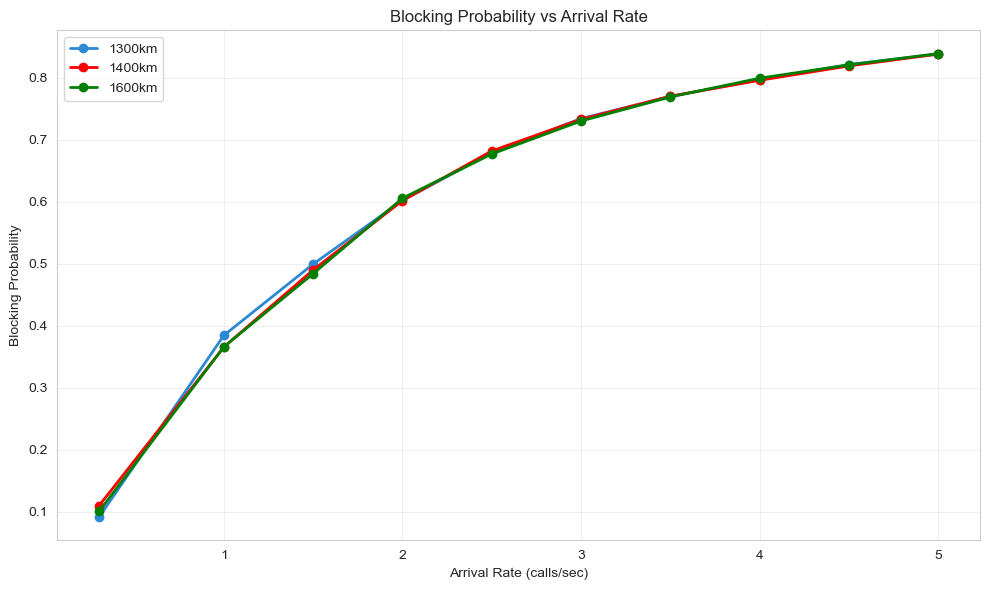

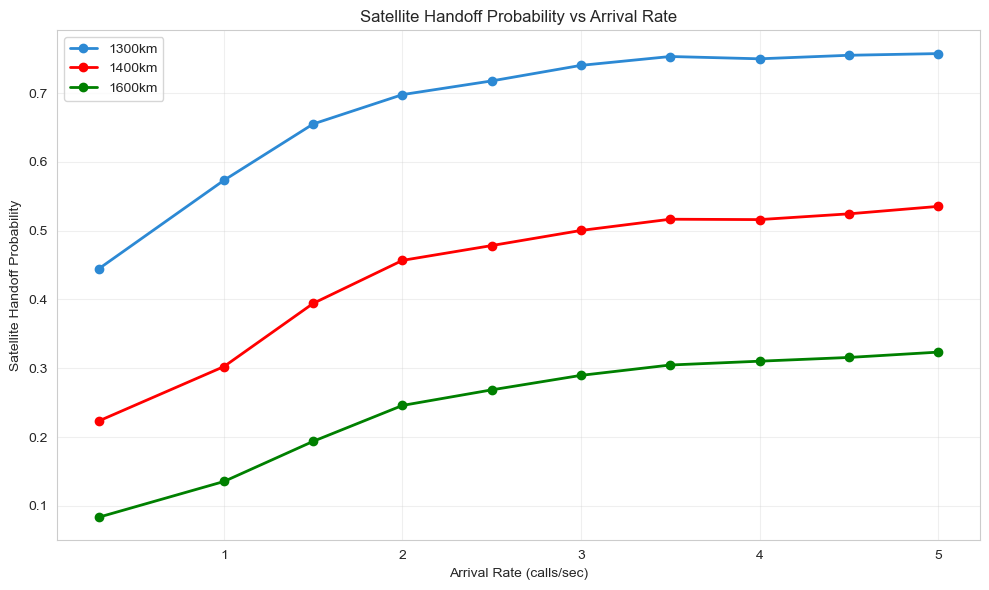

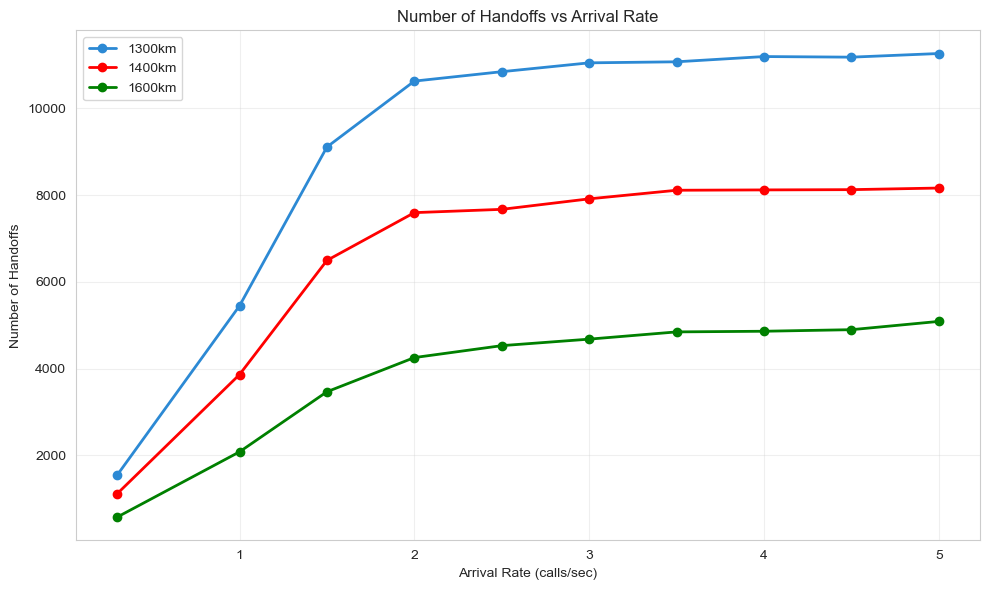


DETAILED RESULTS TABLE

DETAILED METRICS FOR ALL SCENARIOS

SATELLITE HEIGHT: 1300 km
----------------------------------------------------------------------------------------------------
Arrival Rate   Blocking P  Blocking NP    Handoff P   Handoff NP Handoffs P Handoffs NP
 (calls/sec)                                   Prob         Prob    Count    Count
----------------------------------------------------------------------------------------------------
         0.3       0.0915       0.0966       0.4448       0.8251     1543     4634
         1.0       0.3846       0.3732       0.5732       0.8102     5447     9227
         1.5       0.4994       0.4880       0.6550       0.7972     9108    10799
         2.0       0.6018       0.6019       0.6977       0.7951    10627    10972
         2.5       0.6789       0.6781       0.7176       0.7914    10844    11074
         3.0       0.7338       0.7322       0.7402       0.7918    11048    11008
         3.5       0.7696       0.7683    

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

def plot_all_metrics_individual(results):
    """Plot all metrics with different heights as individual plots"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    if df.empty:
        print("No data to plot!")
        return
    
    # Get unique heights and colors for each height
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green', 'orange', 'purple'][:len(heights)]
    
    # Plot 1: Blocking Probability (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_blocking_prob'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Blocking Probability vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Blocking Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Handoff Probability (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoff_prob'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Handoff Probability vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Satellite Handoff Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Number of Handoffs (All heights on same plot)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        
        # Predictive - solid lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                'o-', color=color, linewidth=2, markersize=6, 
                label=f'P {height}km', alpha=0.8)
        
        # Non-Predictive - dashed lines
        plt.plot(height_data['arrival_rate_per_second'], height_data['nonpredictive_handoffs'], 
                's--', color=color, linewidth=2, markersize=6, 
                label=f'NP {height}km', alpha=0.8)
    
    plt.title('Number of Handoffs vs Arrival Rate\n(All Satellite Heights)')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Number of Handoffs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_height_comparison_individual(results):
    """Create individual plots showing how each metric varies with height for predictive vs non-predictive"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    heights = sorted(df['satellite_height_km'].unique())
    colors = ['#2C89D4', 'red', 'green'][:len(heights)]
    
    # Plot 1: Blocking Probability - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_blocking_prob'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Blocking Probability vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Blocking Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Handoff Probability - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoff_prob'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Satellite Handoff Probability vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Satellite Handoff Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Number of Handoffs - Predictive (all heights)
    plt.figure(figsize=(10, 6))
    for height, color in zip(heights, colors):
        height_data = df[df['satellite_height_km'] == height]
        height_data = height_data.sort_values('arrival_rate_per_second')
        plt.plot(height_data['arrival_rate_per_second'], height_data['predictive_handoffs'], 
                'o-', color=color, linewidth=2, markersize=6, label=f'{height}km')
    plt.title('Number of Handoffs vs Arrival Rate')
    plt.xlabel('Arrival Rate (calls/sec)')
    plt.ylabel('Number of Handoffs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_detailed_table(results):
    """Create a detailed table showing all metrics for all scenarios"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"\n{'='*100}")
    print("DETAILED METRICS FOR ALL SCENARIOS")
    print(f"{'='*100}")
    
    # Sort by height and arrival rate
    df_sorted = df.sort_values(['satellite_height_km', 'arrival_rate_per_second'])
    
    for height in sorted(df_sorted['satellite_height_km'].unique()):
        print(f"\nSATELLITE HEIGHT: {height} km")
        print(f"{'-'*100}")
        print(f"{'Arrival Rate':>12} {'Blocking P':>12} {'Blocking NP':>12} {'Handoff P':>12} {'Handoff NP':>12} {'Handoffs P':>8} {'Handoffs NP':>8}")
        print(f"{'(calls/sec)':>12} {'':>12} {'':>12} {'Prob':>12} {'Prob':>12} {'Count':>8} {'Count':>8}")
        print(f"{'-'*100}")
        
        height_data = df_sorted[df_sorted['satellite_height_km'] == height]
        
        for _, row in height_data.iterrows():
            print(f"{row['arrival_rate_per_second']:>12.1f} "
                  f"{row['predictive_blocking_prob']:>12.4f} "
                  f"{row['nonpredictive_blocking_prob']:>12.4f} "
                  f"{row['predictive_handoff_prob']:>12.4f} "
                  f"{row['nonpredictive_handoff_prob']:>12.4f} "
                  f"{row['predictive_handoffs']:>8.0f} "
                  f"{row['nonpredictive_handoffs']:>8.0f}")

def show_all_plots_individual(results):
    """Display all plots as individual figures"""
    
    df = pd.DataFrame([r for r in results if 'error' not in r])
    
    print(f"Total scenarios: {len(df)}")
    print(f"Satellite heights: {sorted(df['satellite_height_km'].unique())}")
    print(f"Arrival rates: {sorted(df['arrival_rate_per_second'].unique())}")
    
    # Plot 1: All metrics comparison
    print("\nPLOT 1: All Metrics Comparison (Individual Plots)")
    #plot_all_metrics_individual(results)
    
    # Plot 2: Predictive metrics by height
    print("\nPLOT 2: Predictive Metrics by Height")
    plot_height_comparison_individual(results)
    
    # Table
    print("\nDETAILED RESULTS TABLE")
    create_detailed_table(results)

# Load results and show plots as individual figures
with open('satellite_height_results2.pkl', 'rb') as f:
    results = pickle.load(f)

show_all_plots_individual(results)